# Using SRIM to calculate displacements according to arc-dpa 

SRIM can be used to calculate displacement damage in ion irradiation.

With the option "Quick Calculation of Damage", SRIM uses internally the NRT model to estimate displacements for each PKA collision. This is the recommended mode for damage calculations so that the results are compatible with international standards.

Here we show how the SRIM output can be manipulated to obtain the damage according to the recently proposed "arc-dpa" model.



## Definitions

The NRT model gives the # of displaced atoms, $\nu$, resulting from a recoil with damage energy $T_{dam}$:

$$
\nu_{NRT}(T_{dam}) = 
\begin{cases}
0 \quad  & 0 < T_{dam} \leq E_d \\
1 \quad  & E_d < T_{dam} \leq L \\
T_{dam}/L \quad & L < T_{dam}
\end{cases}
$$

where $E_d$ is the *displacement threshold* and $L=2.5 E_d$ the *cascade multiplication threshold*.

In the arc-dpa model, the 3rd case in the NRT model is replaced by

$$ \nu_{arc}(T_{dam}) = \nu_{NRT}(T_{dam}) \cdot \xi(T_{dam}) $$

where

$$ \xi(T_{dam}) = (1-c) ( T_{dam}/L )^{b} + c = (1-c) [\nu_{NRT}]^b + c$$

and $b, c$ are material dependent parameters.

The following graph shows the two models in comparison

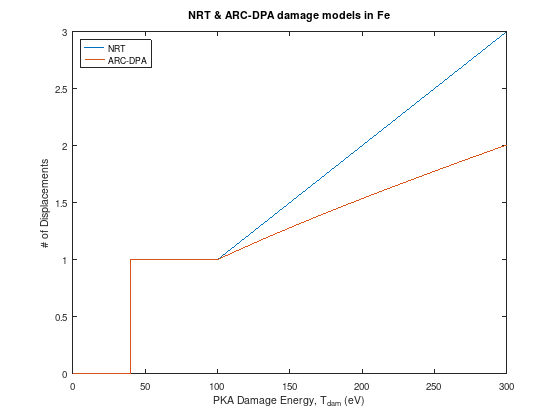

In [1]:
Ed = 40;
L = 2.5*Ed;
Tdam = [0 Ed Ed L linspace(L,300,31)];
% b,c for Fe (Nordlund et al)
b = -0.568;
c = 0.286;
nrt = Tdam/L;
arc = nrt.*((1-c).*nrt.^b+c);
nrt(1:2) = 0; nrt(3:4) = 1;
arc(1:2) = 0; arc(3:4) = 1;
plot(Tdam,[nrt; arc])
xlabel('PKA Damage Energy, T_{dam} (eV)')
ylabel('# of Displacements')
legend('NRT','ARC-DPA','location','northwest')
title('NRT & ARC-DPA damage models in Fe')

## SRIM damage calculation output

The following refer to SRIM calculations with the recommended option "Quick calculation of damage".

From the ``VACANCY.txt`` output file we obtain the average number of displacements per PKA, $\langle \nu_{NRT} \rangle$. This can be used to calculate the damage cross-section, $\sigma_D$ (dpa-cm $^2$), by the following equation

$$
\sigma_D = \int_{E_d}^{T_{max}} {\nu_{NRT}(T_{dam}) \, d\sigma(E,T)} = 
\frac{\langle \nu_{NRT} \rangle \, n_{PKA}}{N_{at}\, d}
$$

where $d\sigma(E,T)$ is the ion-target nucleus differential scattering cross-section, $N_{at}, d$ are the atomic density and thickness of the target, respectively, and $n_{PKA}$ is the average PKA/ion.

The file ``COLLISON.txt`` contains more detailed information for the ion collisions, including the number of vacancies, $\nu_i$, of each specific PKA. The average of $\nu_i$ is equal to $\langle \nu_{NRT} \rangle$:

$$
\langle \nu_{NRT} \rangle = \frac{1}{N_{PKA}}\sum_i {\nu_i}
$$

where $N_{PKA}$ is the total # of PKA generated in the simulation.

## Example data

We have SRIM output data from 3 example calculations shown below. 

All examples are with an Fe target, the displacement threshold was $ E_d = 40 $ eV and the "Quick Calculation of Damage" option was used.

In [2]:
clear % clear all data 
addpath('../m'); % to access srim2mat routines
testcases = { ...
  '1 MeV H ions on Fe target',...
  '5 MeV H ions on Fe target',...
  '2 MeV Fe ions on Fe target'...
  '78 keV Fe ions on Fe target'};
  
testfolders = { ...
  './1MeV_H_on_Fe', ...
  './5MeV_H_on_Fe', ...
  './2MeV_Fe_on_Fe',...
  './78keV_Fe_on_Fe'};

Select one of the above by setting below the variable ``opt``. 

The specified data will be loaded from the corresponding folder.

To save time, the COLLISON.txt of all examples have been preprossed (see [make_collison_dat.m](./make_collison_dat.m)) and converted to binary format (file name ``collison.dat``).

In [4]:
opt = 2; % opt = 1, 2, 3, or 4. Select test case

folder = testfolders{opt};
% load SRIM txt files
A = srim2mat(folder);
% load processed COLISSON data (generates the variable "data")
load([folder '/collison.dat']);
% show variable info
whos A data

Variables visible from the current scope:

variables in scope: top scope

  Attr   Name        Size                     Bytes  Class
  ====   ====        ====                     =====  ===== 
         A           1x1                    7203328  struct
         data   191494x9                   13787568  double

Total is 1723447 elements using 20990896 bytes



## Exploring the COLLISON data matrix

Each row of the matrix ``data`` corresponds to one PKA event. 

The columns have various PKA quantites (see [collison2mat.m](../m/collison2mat.m) for details).

We will use column 8 (PKA recoil energy, $T$) & 9 (generated vacancies, $\nu$). 

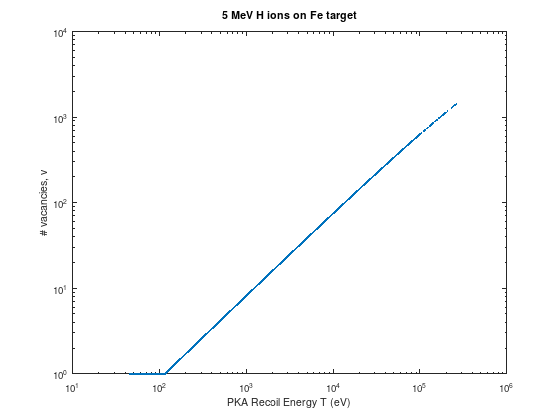

In [5]:
T = data(:,8);
v = data(:,9);
loglog(T,v,'.')
xlabel('PKA Recoil Energy T (eV)')
ylabel('# vacancies, \nu')
title(testcases{opt})

As seen from the figure the # of vacancies is very similar to the NRT. 

It is $\nu=1$ from approx. $E_d=40$ to $2.5\, E_d = 100$ eV and then increases almost linearly.

The small difference from exactly 40 & 100 eV  and the slight non-linearity is because the NRT is a function of damage energy, $T_{dam}$, which is somewhat lower than $T$.

We can easily confirm that the average # of displacements from ``VACANCY.txt`` and ``COLLISON.txt`` is exactly the same: 

In [6]:
disp('Average displacements per PKA, <nu>')
disp(['from VACANCY.txt  : ', num2str(sum(A.Vi+A.Vr)/sum(A.Vi),4)])
Ni = data(end,1); % # of ions
disp(['from COLLISON.txt : ', num2str(mean(v),4)])

Average displacements per PKA, <nu>
from VACANCY.txt  : 3.35
from COLLISON.txt : 3.35


## Obtaining $T_{dam}$

SRIM does not report the damage energy, however, we can obtain it by "reverse engineering" from $\nu_i$ and the NRT definition:

$$ \nu_i = T_{dam} / L \quad\Rightarrow\quad T_{dam}= L \cdot \nu_i $$

To verify that this is correct, we compare the ratio $T_{dam}/T$, also known as *damage efficiency*, to the approximation of Lindhard (see Robinson 1994).

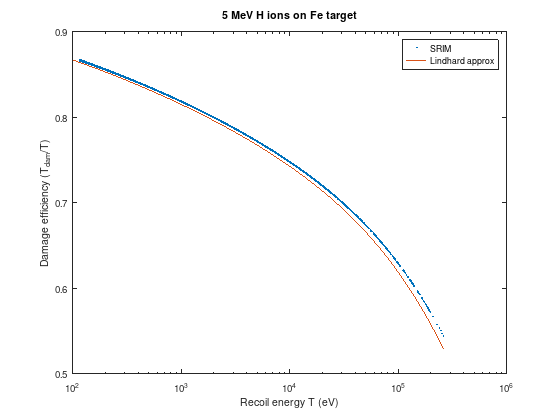

In [7]:
Tdam = v*100; % "reverse engineered" damage energy (eV)

% Lindhard approx from Robinson 1994
function q = damage_efficiency(E,Z,M)
  ah = 0.5292e-8; % Bohr radius in cm
  e2 = 1.4399e-7; % e^2 in eV-cm
  mpme = 1836.15;
  a12 = ah*(9*pi^2/2^1.5/128/Z)^(1/3);
  El = 2*Z^2*e2/a12;
  kl = (32/3/pi)*sqrt(1/mpme/M)*2^(3/4)*Z^(2/3);
  q = E/El;
  q = q + 0.40244*q.^(3/4) + 3.4008*q.^(1/6);
  q = 1./(1+kl*q);
end

i = find(v>1);
x=logspace(2,log10(max(T)),101);
semilogx(T(i),Tdam(i)./T(i),'.',x,damage_efficiency(x,26,55.85))
xlabel('Recoil energy T (eV)');
ylabel('Damage efficiency (T_{dam}/T)');
legend('SRIM','Lindhard approx')
title(testcases{opt})


## The arc-dpa calculation

Now that we have obtained $T_{dam}$ we can do the arc-dpa calculation.

The following code calculates $\xi(T_{dam})$ and arc-dpa and plots the two models for comparison:

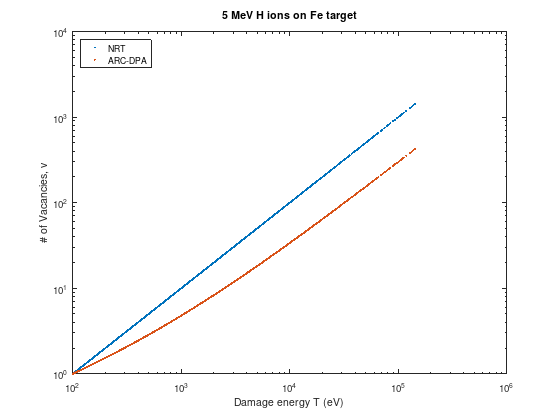

In [8]:
% b,c for Fe (Nordlund et al)
b = -0.568;
c = 0.286;
xi = (1-c)*(v.^b)+c;
loglog(Tdam,v,'.',Tdam,v.*xi,'.')
xlabel('Damage energy T (eV)');
ylabel('# of Vacancies, \nu')
legend('NRT','ARC-DPA','location','northwest')
title(testcases{opt})

## Obtaining the ARC-DPA damage cross-section

For the damage cross-section we need the average # of displacements per PKA. This can be obtained from the $\nu_i$ values in ``COLLISON.txt`` and the corresponding $\xi_i$ values evaluated as shown above. Then the averaging can be written as 

$$\langle \nu_{arc} \rangle = \langle \nu_{NRT} \cdot \xi \rangle = \frac{1}{N_{PKA}} \sum_i {\nu_i \cdot \xi_i}$$

However, as shown in this paper [On the use of SRIM for calculating arc-dpa exposure](https://arxiv.org/abs/2307.12867) we can also obtain an approximate value of $\langle \nu_{arc} \rangle$ as 

$$\langle \nu_{arc} \rangle' \approx (1-c)\, \langle \nu_{NRT} \rangle^{0.56(1+b)} + c\,  \langle \nu_{NRT} \rangle$$

$\langle \nu_{arc} \rangle'$ can be obtained from ``VACANCY.txt`` alone, using the value of $\langle \nu_{NRT} \rangle$ as obtained above.

Thus, $\langle \nu_{arc} \rangle'$ does not require the tedious analysis of COLLISON.txt.

The code below calculates the average displacements/PKA according to NRT and arc-dpa; arc-dpa is calculated both exactly & approx. 

It is observed that the relative error is below $\sim 3\%$.

In [9]:
% from COLLISON.txt
arc = mean(v.*xi);
% from VACANCY.txt
nrt = sum(A.Vi+A.Vr)/sum(A.Vi);
arc1 = (1-c)*nrt.^(0.56*(1+b)) + c*nrt;
disp(['Example: ' testcases{opt}])
disp(['NRT     disp/PKA = ' num2str(nrt,3)])
disp(['arc-dpa disp/PKA = ' num2str(arc,3)])
disp(['Approx arc-dpa   = ' num2str(arc1,3)])
disp(['Diff in arc (%)  = ' num2str((arc1/arc-1)*100,3)])

Example: 5 MeV H ions on Fe target
NRT     disp/PKA = 3.35
arc-dpa disp/PKA = 1.87
Approx arc-dpa   = 1.91
Diff in arc (%)  = 2.2
